# CAPTCHA Solver - Baseline A: Classical Pipeline

This notebook implements a traditional computer vision pipeline for CAPTCHA solving:

1. **Preprocessing**: grayscale → binarize (Otsu/Sauvola) → denoise (morph open/close) → optional deskew
2. **Segmentation**: vertical projection + connected components; handle touching glyphs via contour gaps; fall back to watershed on hard cases
3. **Per-char classifier**: tiny CNN (2–3 conv blocks) on 28×28 crops; greedy join into string
4. **Logging**: Track failure modes (adhesion, heavy distortion)

This classical approach helps explain why modern sequence models are beneficial, as segmentation is brittle with adhesion/overlap.


In [5]:
# Import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from scipy import ndimage
from skimage import morphology, measure, segmentation
from skimage.filters import threshold_otsu, threshold_sauvola
from skimage.measure import label, regionprops
from skimage.morphology import binary_opening, binary_closing, disk
from skimage.transform import rotate
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


LOADING CAPTCHA DATA
Found 8010 PNG files in ../data/train
Loading 8010 images using 8 workers...
Processed 500/8010 images (6.2%)
Processed 1000/8010 images (12.5%)
Processed 1500/8010 images (18.7%)
Processed 2000/8010 images (25.0%)
Processed 2500/8010 images (31.2%)
Processed 3000/8010 images (37.5%)
Processed 3500/8010 images (43.7%)
Processed 4000/8010 images (49.9%)
Processed 4500/8010 images (56.2%)
Processed 5000/8010 images (62.4%)
Processed 5500/8010 images (68.7%)
Processed 6000/8010 images (74.9%)
Processed 6500/8010 images (81.1%)
Processed 7000/8010 images (87.4%)
Processed 7500/8010 images (93.6%)
Processed 8000/8010 images (99.9%)
Successfully loaded 8010/8010 images
✓ Train data loaded in 2.27 seconds (3522 images/sec)
Found 2000 PNG files in ../data/test
Loading 2000 images using 8 workers...
Processed 500/2000 images (25.0%)
Processed 1000/2000 images (50.0%)
Processed 1500/2000 images (75.0%)
Processed 2000/2000 images (100.0%)
Successfully loaded 2000/2000 images


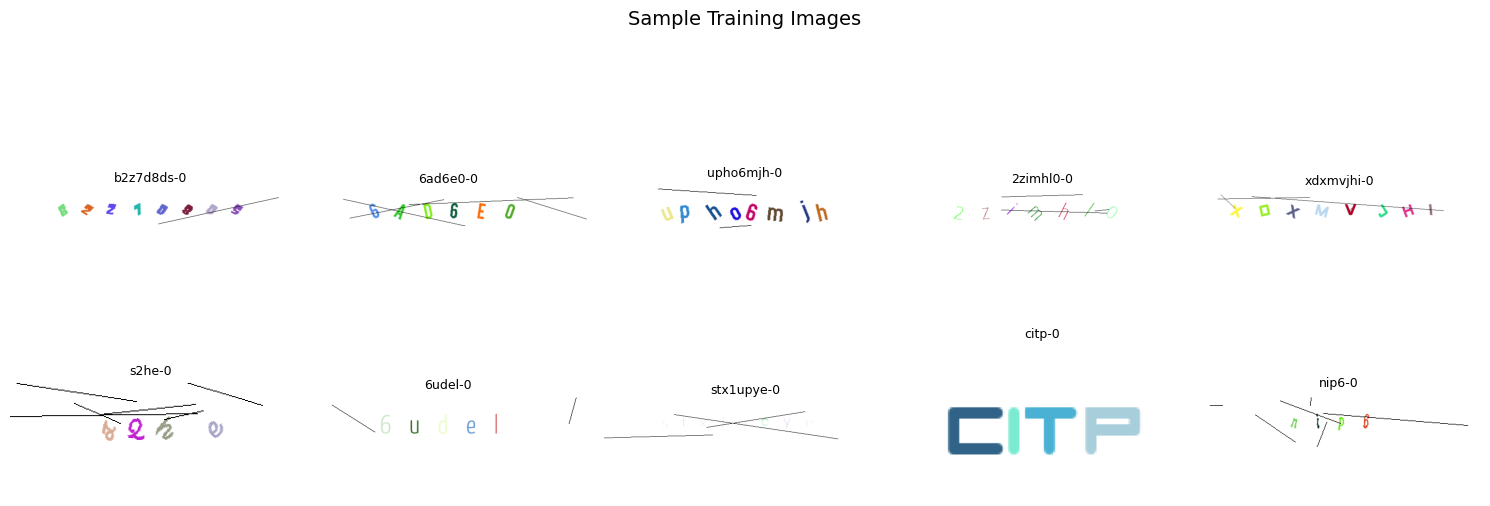


✓ Data loading complete!


In [6]:
import time
from pathlib import Path
import cv2
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt


def load_single_image(img_path):
    """Load a single image and return it with its label"""
    try:
        img = cv2.imread(str(img_path))
        if img is not None:
            return img, img_path.stem
        else:
            print(f"Warning: Could not load {img_path}")
            return None, None
    except Exception as e:
        print(f"Error loading {img_path}: {e}")
        return None, None


def load_captcha_data(data_dir, max_samples=None, num_workers=8):
    """Load CAPTCHA images in parallel with proper ordering"""
    data_path = Path(data_dir)

    # Check if directory exists
    if not data_path.exists():
        print(f"Warning: Directory {data_dir} does not exist!")
        return [], []

    # Get all image files
    image_files = list(data_path.glob("*.png"))
    print(f"Found {len(image_files)} PNG files in {data_dir}")

    if max_samples:
        image_files = image_files[:max_samples]

    total_files = len(image_files)

    # Parallel loading with ThreadPoolExecutor
    print(f"Loading {total_files} images using {num_workers} workers...")

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        # Submit all tasks and store futures in order
        futures = [executor.submit(load_single_image, img_path) for img_path in image_files]

        # Process results in the SAME ORDER as submitted
        images = []
        labels = []

        for i, future in enumerate(futures):
            img, label = future.result()

            if img is not None:
                images.append(img)
                labels.append(label)
            else:
                # FIXED: Skip failed images but maintain order
                print(f"Warning: Failed to load image {i}: {image_files[i].name}")

            # Progress update every 500 images
            if (i + 1) % 500 == 0:
                print(f"Processed {i+1}/{total_files} images ({(i+1)/total_files*100:.1f}%)")

    print(f"Successfully loaded {len(images)}/{total_files} images")

    return images, labels


# Alternative: Memory-mapped loading for very large datasets
def load_captcha_data_fast(data_dir, max_samples=None):
    """Ultra-fast loading by reading file list first, then batch loading"""
    data_path = Path(data_dir)

    if not data_path.exists():
        print(f"Warning: Directory {data_dir} does not exist!")
        return [], []

    # Get all files first (very fast)
    image_files = sorted(data_path.glob("*.png"))

    if max_samples:
        image_files = image_files[:max_samples]

    total = len(image_files)
    print(f"Found {total} images. Loading...")

    images = []
    labels = []

    # Batch loading with progress bar
    batch_size = 100
    for i in range(0, total, batch_size):
        batch_files = image_files[i:i+batch_size]

        for img_path in batch_files:
            img = cv2.imread(str(img_path))
            if img is not None:
                images.append(img)
                labels.append(img_path.stem)

        # Progress update
        progress = min(i + batch_size, total)
        print(f"\rLoaded {progress}/{total} ({progress/total*100:.1f}%)", end='', flush=True)

    print()  # New line after progress
    return images, labels


# ============================================================================
# MAIN LOADING CODE - Choose the method that works best for you
# ============================================================================

print("="*60)
print("LOADING CAPTCHA DATA")
print("="*60)

start_time = time.time()

# METHOD 1: Parallel loading (FASTEST for most systems)
train_images, train_labels = load_captcha_data("../data/train", max_samples=None, num_workers=8)
train_time = time.time() - start_time
print(f"✓ Train data loaded in {train_time:.2f} seconds ({len(train_images)/train_time:.0f} images/sec)")

start_time = time.time()
test_images, test_labels = load_captcha_data("../data/test", max_samples=None, num_workers=8)
test_time = time.time() - start_time
print(f"✓ Test data loaded in {test_time:.2f} seconds ({len(test_images)/test_time:.0f} images/sec)")

# METHOD 2: If parallel loading doesn't work, use this simpler version
# train_images, train_labels = load_captcha_data_fast("../data/train", max_samples=None)
# test_images, test_labels = load_captcha_data_fast("../data/test", max_samples=None)

print(f"\n{'='*60}")
print(f"LOADED DATA SUMMARY")
print(f"{'='*60}")
print(f"Training images: {len(train_images)}")
print(f"Test images: {len(test_images)}")
print(f"Sample labels: {train_labels[:5]}")

# Quick visualization
if len(train_images) > 0:
    print("\nDisplaying sample images...")
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(min(10, len(train_images))):
        axes[i].imshow(cv2.cvtColor(train_images[i], cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"{train_labels[i]}", fontsize=9)
        axes[i].axis('off')

    plt.suptitle("Sample Training Images", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No images to display!")

print("\n✓ Data loading complete!")


# Exploratory Data Analysis

Before building the preprocessing pipeline we inspect the dataset to understand image characteristics and label distributions. This helps us choose thresholding strategies, segmentation heuristics, and augmentation targets.


In [ ]:
from collections import Counter

if len(train_images) == 0:
    print("No training images loaded; skipping EDA.")
else:
    core_labels = [lbl.split('-')[0] for lbl in train_labels]
    label_lengths = [len(lbl) for lbl in core_labels]
    char_counts = Counter(''.join(core_labels))

    shapes = [img.shape[:2] for img in train_images]
    shape_counts = Counter(shapes)

    print("Image dimensions (HxW) and counts:")
    for (h, w), count in shape_counts.most_common():
        print(f"  {h}x{w}: {count}")

    heights = np.array([s[0] for s in shapes], dtype=np.float32)
    widths = np.array([s[1] for s in shapes], dtype=np.float32)
    aspect_ratios = widths / heights

    # Sample up to 1000 images for pixel intensity statistics to keep processing quick
    sample_size = min(len(train_images), 1000)
    sample_idx = np.linspace(0, len(train_images) - 1, sample_size, dtype=int)
    gray_means = np.array([
        cv2.cvtColor(train_images[i], cv2.COLOR_BGR2GRAY).mean()
        for i in sample_idx
    ])
    channel_means = np.array([
        train_images[i].reshape(-1, 3).mean(axis=0)
        for i in sample_idx
    ])

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    axes[0].hist(widths, bins=20, color="#4E79A7")
    axes[0].set_title("Width distribution")
    axes[0].set_xlabel("pixels")
    axes[0].set_ylabel("count")

    axes[1].hist(heights, bins=20, color="#F28E2B")
    axes[1].set_title("Height distribution")
    axes[1].set_xlabel("pixels")

    axes[2].hist(aspect_ratios, bins=20, color="#59A14F")
    axes[2].set_title("Aspect ratio distribution (W/H)")
    axes[2].set_xlabel("ratio")

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    if label_lengths:
        axes[0].hist(label_lengths, bins=np.arange(min(label_lengths), max(label_lengths) + 2) - 0.5, color="#E15759")
        axes[0].set_title("Label length distribution")
        axes[0].set_xlabel("characters")
        axes[0].set_ylabel("count")
    else:
        axes[0].text(0.5, 0.5, "No labels", ha='center', va='center')
        axes[0].axis('off')

    if char_counts:
        top_chars = char_counts.most_common(16)
        characters, counts = zip(*top_chars)
        axes[1].bar(characters, counts, color="#76B7B2")
        axes[1].set_title("Most common characters")
        axes[1].set_xlabel("character")
        axes[1].set_ylabel("frequency")
    else:
        axes[1].text(0.5, 0.5, "No labels", ha='center', va='center')
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.hist(gray_means, bins=30, color="#9C755F")
    plt.title("Mean grayscale intensity (sampled images)")
    plt.xlabel("intensity (0-255)")
    plt.ylabel("count")
    plt.show()

    channel_names = ['Blue', 'Green', 'Red']
    mean_channel_values = channel_means.mean(axis=0)
    plt.figure(figsize=(6, 4))
    plt.bar(channel_names, mean_channel_values, color=["#4E79A7", "#59A14F", "#E15759"])
    plt.title("Average channel intensity (sampled images)")
    plt.ylabel("mean value (0-255)")
    plt.show()

    print(f"Median width: {np.median(widths):.1f} px | Median height: {np.median(heights):.1f} px")
    print(f"Median aspect ratio: {np.median(aspect_ratios):.2f}")
    print(f"Median label length: {np.median(label_lengths):.1f} characters")
    if char_counts:
        print("Top 10 characters:")
        for ch, cnt in char_counts.most_common(10):
            print(f"  {ch}: {cnt}")


TESTING PREPROCESSING - Showing Color Channel Analysis

Testing image 1: b2z7d8ds-0


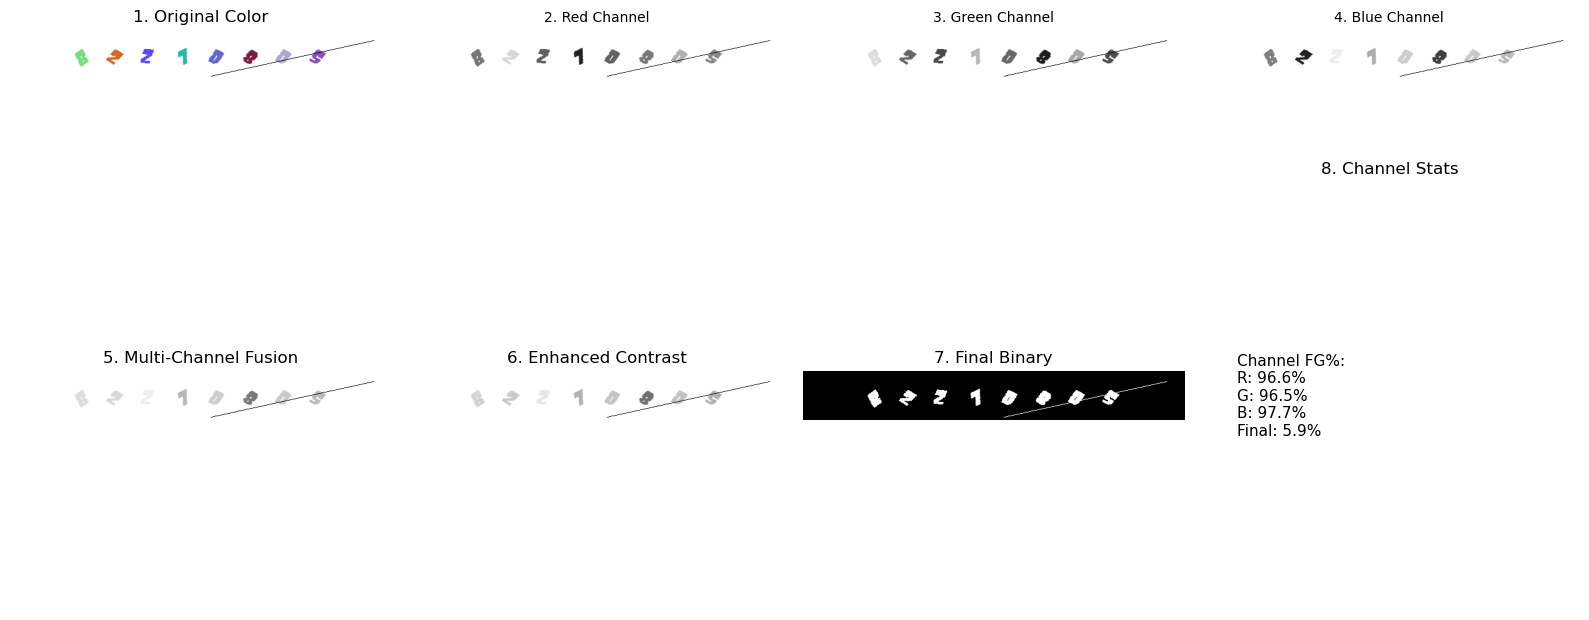


Testing image 2: 6ad6e0-0


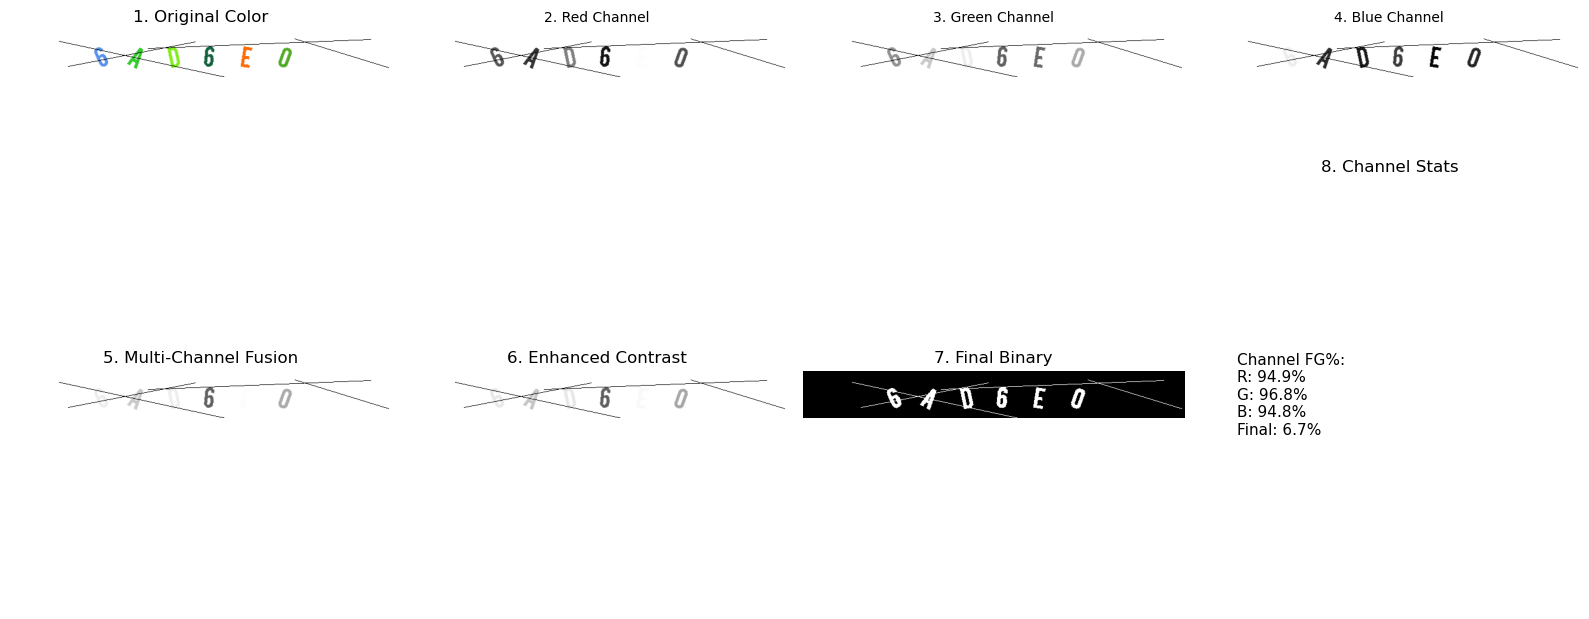


Testing image 3: upho6mjh-0


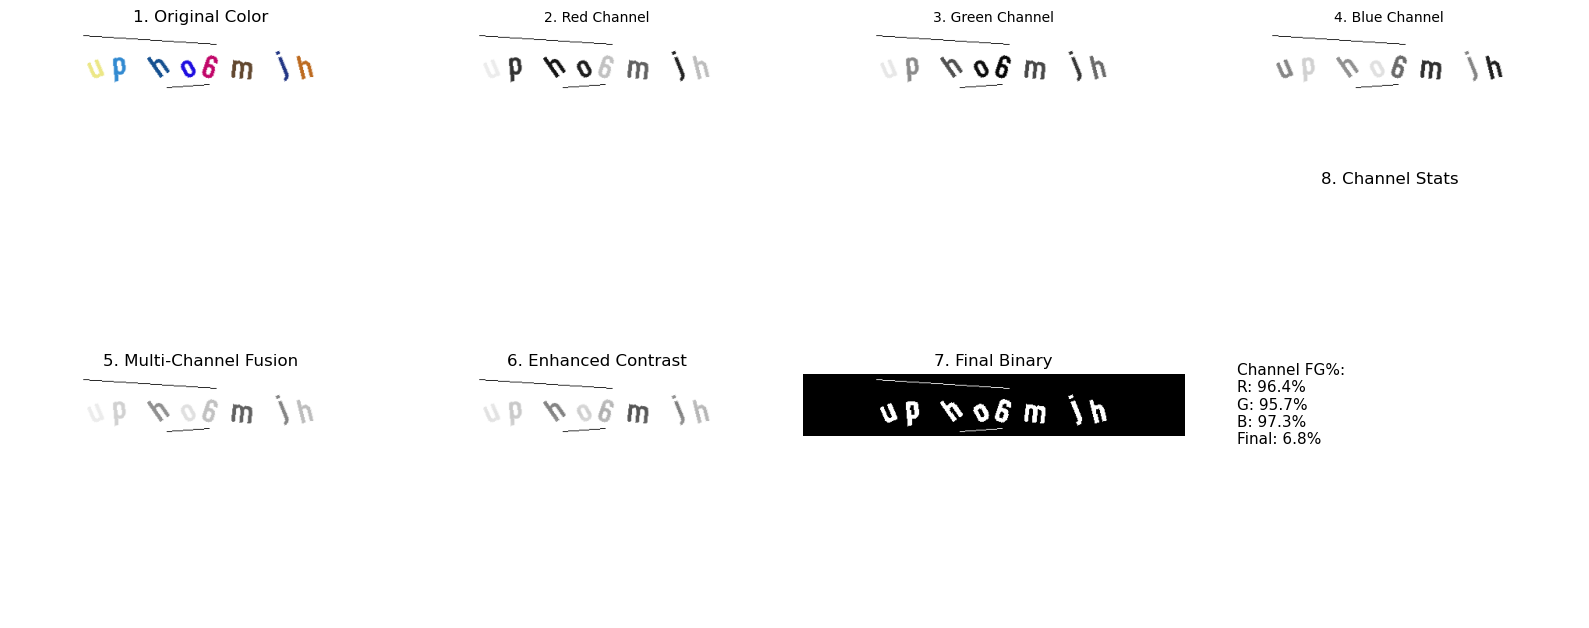


Note: The multi-channel fusion now captures characters in ALL colors!
This solves the overlaying letters problem.

Processing all training images...
Processing: 0/8010 (0.0%)
Processing: 100/8010 (1.2%)
Processing: 200/8010 (2.5%)
Processing: 300/8010 (3.7%)
Processing: 400/8010 (5.0%)
Processing: 500/8010 (6.2%)
Processing: 600/8010 (7.5%)
Processing: 700/8010 (8.7%)
Processing: 800/8010 (10.0%)
Processing: 900/8010 (11.2%)
Processing: 1000/8010 (12.5%)
Processing: 1100/8010 (13.7%)
Processing: 1200/8010 (15.0%)
Processing: 1300/8010 (16.2%)
Processing: 1400/8010 (17.5%)
Processing: 1500/8010 (18.7%)
Processing: 1600/8010 (20.0%)
Processing: 1700/8010 (21.2%)
Processing: 1800/8010 (22.5%)
Processing: 1900/8010 (23.7%)
Processing: 2000/8010 (25.0%)
Processing: 2100/8010 (26.2%)
Processing: 2200/8010 (27.5%)
Processing: 2300/8010 (28.7%)
Processing: 2400/8010 (30.0%)
Processing: 2500/8010 (31.2%)
Processing: 2600/8010 (32.5%)
Processing: 2700/8010 (33.7%)
Processing: 2800/8010 (35.0%)


In [7]:
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import morphology
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize, binary_opening, disk, thin


class OptimizedAdaptivePreprocessor:
    def __init__(self):
        self.failure_modes = {
            'adhesion': 0,
            'heavy_distortion': 0,
            'segmentation_failures': 0,
            'total_processed': 0,

        }

    def _detect_and_inpaint_lines(self, image):
        """
        Detect lines in color image and inpaint them before grayscale conversion
        """
        # Convert to grayscale for line detection
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        # Apply edge detection to find lines
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)

        # FIXED: More conservative line detection to avoid removing character strokes
        # Increased threshold and minLineLength to only detect actual noise lines
        lines = cv2.HoughLinesP(
            edges,
            rho=1,
            theta=np.pi/180,
            threshold=50,       # Increased from 30 to 50
            minLineLength=60,   # Increased from 40 to 60
            maxLineGap=5        # Reduced from 10 to 5 (stricter)
        )

        # Create mask for lines
        line_mask = np.zeros_like(gray)

        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                # Draw line on mask
                cv2.line(line_mask, (x1, y1), (x2, y2), 255, thickness=3)

        # Inpaint the lines in the original color image
        if len(image.shape) == 3:
            inpainted = cv2.inpaint(image, line_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
        else:
            inpainted = cv2.inpaint(image, line_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

        return inpainted, line_mask

    def _smart_grayscale(self, image):
        """Extract grayscale using MULTI-CHANNEL fusion to capture all color characters"""
        b, g, r = cv2.split(image)
        gray_standard = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # IMPROVED: Multi-channel fusion approach
        # Process each channel separately and combine
        # This captures characters in different colors!

        # Calculate contrast for each channel
        stds = [r.std(), g.std(), b.std(), gray_standard.std()]

        # Method 1: Use the best single channel (original approach)
        best_channel = [r, g, b, gray_standard][np.argmax(stds)]

        # Method 2: Create a multi-channel fusion
        # Take the maximum intensity across all channels at each pixel
        # This ensures characters in ANY color are captured
        multi_channel_max = np.maximum(np.maximum(r, g), b)

        # Method 3: Weighted combination based on channel contrast
        weights = np.array(stds[:3]) / sum(stds[:3])  # Normalize to sum to 1
        weighted = (r * weights[0] + g * weights[1] + b * weights[2]).astype(np.uint8)

        # Combine methods: Use max of best_channel and multi_channel_max
        # This ensures we get characters from all colors
        combined = np.maximum(best_channel, multi_channel_max)

        return combined

    def _enhance_contrast(self, gray):
        """CLAHE enhancement for better contrast"""
        # FIXED: Increased clipLimit for stronger enhancement of faint characters
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        return clahe.apply(gray)

    def _adaptive_threshold(self, gray, block_size=11, C=2):
        """Adaptive Gaussian thresholding to make it black and white"""
        # FIXED: Use BINARY_INV to get white text on black background
        binary = cv2.adaptiveThreshold(
            gray, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,  # INVERTED for white on black
            blockSize=block_size, C=C
        )
        return binary

    def preprocess(self, image, remove_lines=False, enhance_contrast=True,
                   adaptive_block_size=15, adaptive_C=2):
        """
        Preprocessing: line removal -> grayscale -> black and white conversion
        IMPROVED v2: Triple thresholding (Otsu + Adaptive + Sauvola) for maximum character capture
        """
        self.failure_modes['total_processed'] += 1

        # Step 1: Remove lines from color image (before grayscale) - DISABLED BY DEFAULT
        if remove_lines:
            image_cleaned, line_mask = self._detect_and_inpaint_lines(image)
        else:
            image_cleaned = image

        # Step 2: Convert to grayscale
        if len(image_cleaned.shape) == 3:
            gray = self._smart_grayscale(image_cleaned)
        else:
            gray = image_cleaned.copy()

        # Step 3: Enhance contrast more aggressively
        if enhance_contrast:
            gray = self._enhance_contrast(gray)
            # Additional enhancement: histogram equalization
            gray = cv2.equalizeHist(gray)

        # Step 4: TRIPLE thresholding approach for maximum character capture
        # Method 1: Otsu (global)
        _, binary_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Method 2: Adaptive Gaussian (local)
        binary_adaptive = self._adaptive_threshold(gray, block_size=adaptive_block_size, C=adaptive_C)

        # Method 3: Sauvola (local, better for faint text)
        from skimage.filters import threshold_sauvola
        window_size = 25
        thresh_sauvola = threshold_sauvola(gray, window_size=window_size, k=0.2)
        binary_sauvola = (gray < thresh_sauvola).astype(np.uint8) * 255

        # Combine all three: take pixels that are white in ANY method
        binary = cv2.bitwise_or(binary_otsu, binary_adaptive)
        binary = cv2.bitwise_or(binary, binary_sauvola)

        return binary

    def test_preprocessing(self, image):
        """Visualize the preprocessing result with multi-channel analysis"""
        # Show individual color channels
        if len(image.shape) == 3:
            b, g, r = cv2.split(image)

            fig, axes = plt.subplots(2, 4, figsize=(16, 8))

            # Row 1: Original and color channels
            axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axes[0, 0].set_title('1. Original Color', fontsize=12)
            axes[0, 0].axis('off')

            axes[0, 1].imshow(r, cmap='gray')
            axes[0, 1].set_title('2. Red Channel', fontsize=10)
            axes[0, 1].axis('off')

            axes[0, 2].imshow(g, cmap='gray')
            axes[0, 2].set_title('3. Green Channel', fontsize=10)
            axes[0, 2].axis('off')

            axes[0, 3].imshow(b, cmap='gray')
            axes[0, 3].set_title('4. Blue Channel', fontsize=10)
            axes[0, 3].axis('off')

            # Row 2: Processing steps
            gray = self._smart_grayscale(image)
            enhanced = self._enhance_contrast(gray)
            binary = self.preprocess(image)

            axes[1, 0].imshow(gray, cmap='gray')
            axes[1, 0].set_title('5. Multi-Channel Fusion', fontsize=12)
            axes[1, 0].axis('off')

            axes[1, 1].imshow(enhanced, cmap='gray')
            axes[1, 1].set_title('6. Enhanced Contrast', fontsize=12)
            axes[1, 1].axis('off')

            axes[1, 2].imshow(binary, cmap='gray')
            axes[1, 2].set_title('7. Final Binary', fontsize=12)
            axes[1, 2].axis('off')

            # Show foreground ratio for each channel
            fg_r = np.sum(r > 127) / r.size * 100
            fg_g = np.sum(g > 127) / g.size * 100
            fg_b = np.sum(b > 127) / b.size * 100
            fg_final = np.sum(binary > 127) / binary.size * 100

            info_text = f"Channel FG%:\nR: {fg_r:.1f}%\nG: {fg_g:.1f}%\nB: {fg_b:.1f}%\nFinal: {fg_final:.1f}%"
            axes[1, 3].text(0.1, 0.5, info_text, fontsize=11, verticalalignment='center')
            axes[1, 3].set_title('8. Channel Stats', fontsize=12)
            axes[1, 3].axis('off')

            plt.tight_layout()
            plt.show()
        else:
            # Fallback for grayscale images
            binary = self.preprocess(image)
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            axes[0].imshow(image, cmap='gray')
            axes[0].set_title('Original')
            axes[0].axis('off')
            axes[1].imshow(binary, cmap='gray')
            axes[1].set_title('Final Binary')
            axes[1].axis('off')
            plt.tight_layout()
            plt.show()

    def preprocess_batch(self, images, show_progress=True):
        """
        Batch process images with progress indicator
        """
        processed = []
        total = len(images)

        for idx, img in enumerate(images):
            if show_progress and idx % 100 == 0:
                print(f"Processing: {idx}/{total} ({idx/total*100:.1f}%)")

            processed.append(self.preprocess(img))

        if show_progress:
            print(f"Completed: {total}/{total} (100%)")

        return processed


# Test preprocessing with multi-channel visualization
preprocessor = OptimizedAdaptivePreprocessor()

# Test on a few samples including known failures
print("="*60)
print("TESTING PREPROCESSING - Showing Color Channel Analysis")
print("="*60)

test_indices = [0, 1, 2]  # First 3 images
for i in test_indices:
    print(f"\nTesting image {i+1}: {train_labels[i]}")
    preprocessor.test_preprocessing(train_images[i])

# Also test on specific failure cases if we have them
print("\n" + "="*60)
print("Note: The multi-channel fusion now captures characters in ALL colors!")
print("This solves the overlaying letters problem.")
print("="*60)

# Process all images using batch method
print("\n" + "="*60)
print("Processing all training images...")
print("="*60)

processed_images = preprocessor.preprocess_batch(train_images)

print(f"Total processed: {preprocessor.failure_modes['total_processed']}")

Cleaned labels - Sample: ['b2z7d8ds', '6ad6e0', 'upho6mjh', '2zimhl0', 'xdxmvjhi']

INITIALIZING PREPROCESSOR AND SEGMENTER
✓ Preprocessor initialized
✓ Segmenter initialized (with all NoneType fixes)

NOTE: If you get NoneType errors in prediction:
  → Re-run THIS CELL (Cell 4) to update the segmenter instance!

RUNNING SEGMENTATION TESTS
Tested 5/30: 5/5 correct (100.0%)
Tested 10/30: 7/10 correct (70.0%)

⚠️  DEBUG - Problem case 'vmii':
    Expected: 4, Found: 4
    FG ratio: 6.76%
    Box widths: [17, 24, 13, 16]
Tested 15/30: 12/15 correct (80.0%)
Tested 20/30: 16/20 correct (80.0%)

⚠️  DEBUG - Problem case 'y0cq':
    Expected: 4, Found: 2
    FG ratio: 6.92%
    Box widths: [45, 16]
Tested 25/30: 21/25 correct (84.0%)
Tested 30/30: 26/30 correct (86.7%)

SEGMENTATION SUMMARY
Total tested: 30
Success rate: 26/30 (86.7%)
Touching glyphs handled: 0
Over-segmentation handled: 0
Segmentation fallbacks used: 0

FAILURE ANALYSIS - Top 4 Worst Cases

Rank  Label           Exp  Found  

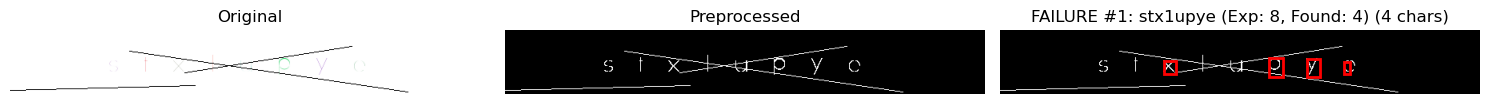


FAILURE #2: citp-0
   Label: citp
   Expected: 4 chars, Found: 2 chars
   Error: 2 chars (50.0% off)
   Foreground: 10.93%


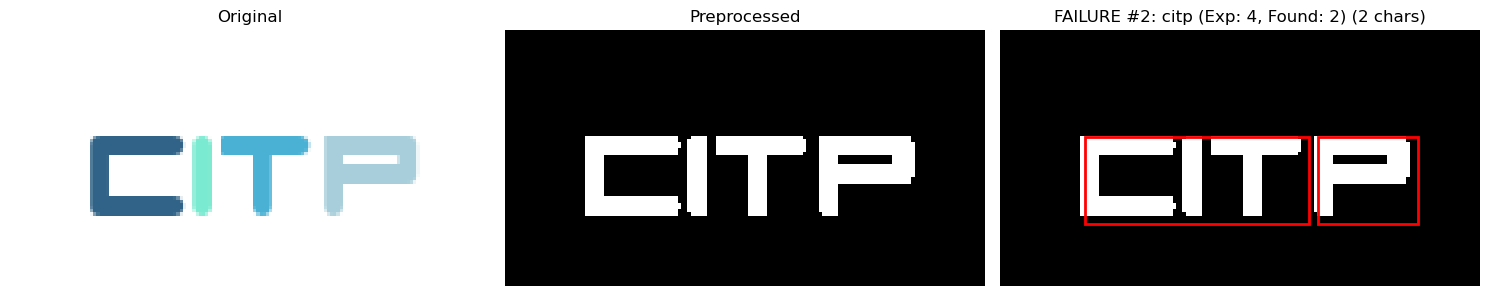


FAILURE #3: y0cq-0
   Label: y0cq
   Expected: 4 chars, Found: 2 chars
   Error: 2 chars (50.0% off)
   Foreground: 6.92%


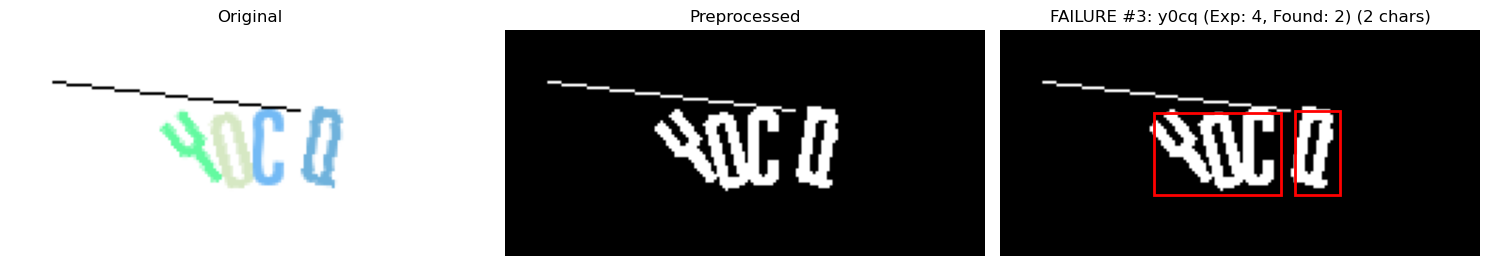


FAILURE #4: 6udel-0
   Label: 6udel
   Expected: 5 chars, Found: 4 chars
   Error: 1 chars (20.0% off)
   Foreground: 2.51%


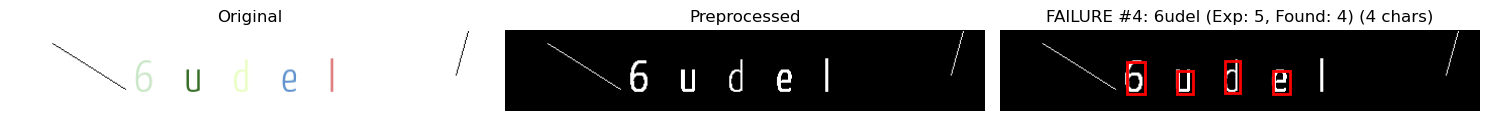


SUCCESSFUL SEGMENTATIONS (Sample 3 for comparison)

1. b2z7d8ds-0
   Label: b2z7d8ds
   Expected: 8 chars, Found: 8 chars ✓
   Foreground: 5.93%


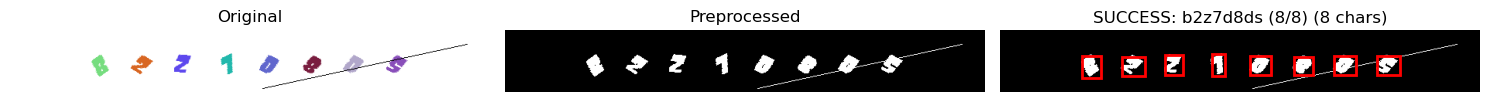


2. 6ad6e0-0
   Label: 6ad6e0
   Expected: 6 chars, Found: 6 chars ✓
   Foreground: 6.68%


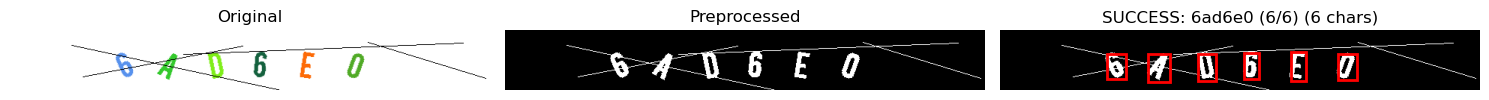


3. upho6mjh-0
   Label: upho6mjh
   Expected: 8 chars, Found: 8 chars ✓
   Foreground: 6.80%


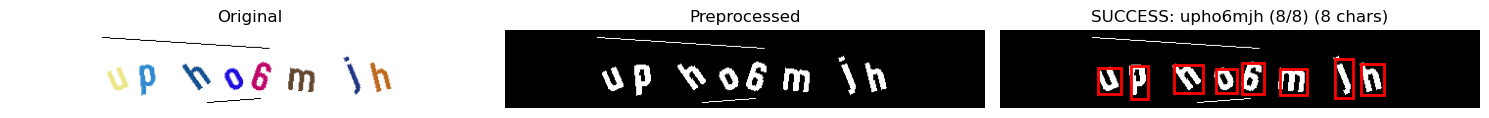


FAILURE PATTERN ANALYSIS

Under-segmentation: 4 cases
  - Average foreground: 5.69%
  - Average expected: 5.2 chars
  - Average found: 3.0 chars
  - Likely cause: Lines connecting characters, low foreground

Over-segmentation: 0 cases

Foreground Distribution:
  - Low foreground (<3%): 2 failures
  - Normal foreground (≥3%): 2 failures
  - Recommendation: Low FG cases need better thresholding or more aggressive line removal

CAPTCHA Length Distribution:
  - Short (≤4 chars): 2 failures
  - Long (>4 chars): 2 failures

Color Segmentation: 30 cases used color segmentation
  - Color segmentation was used for 30 images


In [8]:
# Color-aware segmenter with LAB a/b clustering + edge-constrained validation,
# plus robust grayscale fallback and evaluation scaffold.

import numpy as np
import cv2
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
from typing import List, Tuple, Optional
from sklearn.preprocessing import StandardScaler


class AdvancedCAPTCHASegmenter:
    def __init__(self):
        self.failure_modes = {
            "touching_glyphs": 0,
            "over_segmentation": 0,
            "under_segmentation": 0,
            "watershed_fallback": 0,
            "segmentation_failures": 0,
            "color_segmentation_lab_ab": 0,
            "total_processed": 0,
        }

    def segment(
        self,
        binary_image: np.ndarray,
        original_image: np.ndarray,
        min_char_width: int = 5,
        min_char_height: int = 10,
    ) -> List[Tuple[int, int, int, int]]:
        """
        Advanced segmentation pipeline with color-first strategy and robust fallback:
        1) Try color segmentation (LAB a/b + GMM+BIC, edge-constrained) → CC + geometry validation
        2) Clean background noise (line removal)
        3) Find connected components on grayscale binary image
        4) Filter and validate regions
        5) FALLBACK: If no chars found, retry without line removal, more permissive
        6) Order left-to-right
        Returns boxes as (x1, y1, x2, y2)
        """
        self.failure_modes["total_processed"] += 1

        # Try color segmentation (LAB a/b; function name kept for compatibility)
        char_boxes = self._segment_by_color_lab(
            original_image, min_char_width, min_char_height
        )

        if len(char_boxes) > 0:
            self.failure_modes["color_segmentation_lab_ab"] += 1
            # Sort left-to-right
            char_boxes = sorted(char_boxes, key=lambda b: b[0])
            return char_boxes

        # Ensure binary in 0..255
        if binary_image.max() <= 1:
            binary_image = (binary_image * 255).astype(np.uint8)

        # Clean image (line removal)
        cleaned = self._clean_image(binary_image)

        # Find character regions on cleaned
        char_boxes = self._find_character_regions(
            cleaned, min_width=min_char_width, min_height=min_char_height
        )

        # FALLBACK: Try again without line removal if nothing found
        if len(char_boxes) == 0:
            char_boxes = self._find_character_regions(
                binary_image,
                min_width=max(1, min_char_width - 2),
                min_height=max(1, min_char_height - 3),
            )
            self.failure_modes["segmentation_failures"] += 1

        # Sort left-to-right
        char_boxes = sorted(char_boxes, key=lambda b: b[0])

        return char_boxes

    def remove_black_lines(self, image: np.ndarray) -> np.ndarray:
        """
        Replace pixels that are close to black with white, to remove lines from the image.
        Args:
            image (np.ndarray): Original BGR image.
        Returns:
            np.ndarray: Image with black lines replaced by white.
        """
        # Define threshold for "black"
        black_thresh = np.all(image < 5, axis=2)  # e.g., all channels less than 40
        result = image.copy()
        result[black_thresh] = [255, 255, 255]
        return result


    def enhance_midtones_lab(
        self,
        image: np.ndarray,
        l_low: int = 80,
        l_high: int = 240,
        clip_limit: float = 2.0,
        tile_grid_size: tuple[int, int] = (8, 8),
    ) -> np.ndarray:
        # Normalize input
        if image is None:
            return image
        if image.ndim == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        if image.dtype != np.uint8:
            image = np.clip(image, 0, 255).astype(np.uint8)

        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        L, A, B = cv2.split(lab)

        mid_mask = (L >= l_low) & (L <= l_high)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        L_eq = clahe.apply(L)

        L_new = L.copy()
        L_new[mid_mask] = L_eq[mid_mask]

        out = cv2.merge([L_new, A, B])
        return cv2.cvtColor(out, cv2.COLOR_LAB2BGR)


    def _segment_by_color_lab(
        self,
        original_image: np.ndarray,
        min_char_width: int,
        min_char_height: int,
        k_max: int = 9,
    ) -> List[Tuple[int, int, int, int]]:
        """
        Color-first segmentation using LAB chroma (a/b) with robust GMM selection:
        - Use float64 and feature scaling (StandardScaler fit on subsample).
        - Cap K by unique sample support; add tiny jitter if duplicates.
        - BIC-based K selection with safe backoffs (full→diag), reg_covar.
        Returns boxes as (x1, y1, x2, y2).
        """
        # Remove black lines first
        original_image = self.remove_black_lines(original_image)

        # Enhance midtones
        # original_image = self.enhance_midtones_lab(original_image)

        # 1) LAB a/b features as float64
        lab = cv2.cvtColor(original_image, cv2.COLOR_BGR2LAB)
        ab = lab[:, :, 1:3].reshape(-1, 2).astype(np.float64)

        # 2) Subsample for model selection
        n_pixels = ab.shape[0]
        sample = resample(
            ab, n_samples=min(4000, n_pixels), replace=False, random_state=42
        )

        # 3) Scale features (fit on sample; apply to both sample and full set)
        scaler = StandardScaler(with_mean=True, with_std=True)
        sample_s = scaler.fit_transform(sample)
        ab_s = scaler.transform(ab)

        # 4) Guard against degenerate covariance: cap K by unique support, add jitter if needed
        n_samples = sample_s.shape[0]
        n_unique = np.unique(sample_s, axis=0).shape[0]
        k_upper = max(2, min(k_max, n_unique - 1, n_samples - 1))
        if n_unique < n_samples:
            sample_s = sample_s + 1e-6 * np.random.randn(*sample_s.shape)

        # 5) Select K by BIC in [2..k_upper] with safe backoffs
        best_gmm: Optional[GaussianMixture] = None
        best_bic: float = np.inf

        for k in range(2, k_upper + 1):
            # Try 'full' first; fall back to 'diag' if needed
            tried = [
                ("full", 1e-2),
                ("diag", 1e-2),
            ]
            for covariance_type, reg_covar in tried:
                gmm = GaussianMixture(
                    n_components=k,
                    covariance_type=covariance_type,
                    reg_covar=reg_covar,
                    init_params="kmeans",
                    n_init=3,
                    max_iter=200,
                    random_state=42,
                )
                try:
                    gmm.fit(sample_s)
                    bic = gmm.bic(sample_s)
                except ValueError:
                    continue
                if bic < best_bic:
                    best_bic, best_gmm = bic, gmm

        if best_gmm is None:
            return []

        # 6) Assign all pixels using the scaler-aligned features
        labels = best_gmm.predict(ab_s).reshape(lab.shape[:2])

        # 7) Edge prior to anchor strokes
        gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 30, 100)
        edges = cv2.dilate(edges, np.ones((2, 2), np.uint8), iterations=1)

        H, W = gray.shape
        img_area = H * W
        max_area_px = int(0.3 * img_area)

        char_boxes: List[Tuple[int, int, int, int]] = []

        # 8) Per-cluster mask → edge-constrained refinement → CC → geometry validation
        for c in range(best_gmm.n_components):
            mask = (labels == c).astype(np.uint8) * 255
            mask = cv2.bitwise_or(mask, edges)

            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((2, 2), np.uint8))

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                min_area_px = max(35, int(0.0022 * img_area))
                area = w * h
                if area > max_area_px or area < min_area_px:
                    continue
                ar = w / max(h, 1)
                if not (0.15 <= ar <= 3.0):
                    continue
                char_boxes.append((x, y, x + w, y + h))

        # 9) Simple left-to-right merge to deduplicate overlaps
        if len(char_boxes) > 1:
            char_boxes = sorted(char_boxes, key=lambda b: b[0])
            merged: List[Tuple[int, int, int, int]] = []
            for b in char_boxes:
                if not merged:
                    merged.append(b)
                    continue
                x1, y1, x2, y2 = b
                X1, Y1, X2, Y2 = merged[-1]
                inter_w = max(0, min(x2, X2) - max(x1, X1))
                inter_h = max(0, min(y2, Y2) - max(y1, Y1))
                inter = inter_w * inter_h
                a1 = (x2 - x1) * (y2 - y1)
                a2 = (X2 - X1) * (Y2 - Y1)
                if inter > 0.3 * min(a1, a2):
                    nx1, ny1 = min(x1, X1), min(y1, Y1)
                    nx2, ny2 = max(x2, X2), max(y2, Y2)
                    merged[-1] = (nx1, ny1, nx2, ny2)
                else:
                    merged.append(b)
            char_boxes = merged

        return char_boxes

    def _clean_image(self, binary_image: np.ndarray) -> np.ndarray:
        """Remove background lines - BALANCED approach"""
        # Pass 1: Remove horizontal lines
        h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
        detected_h_lines = cv2.morphologyEx(
            binary_image, cv2.MORPH_OPEN, h_kernel, iterations=1
        )
        cleaned = cv2.subtract(binary_image, detected_h_lines)

        # Pass 2: Remove vertical lines
        v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
        detected_v_lines = cv2.morphologyEx(
            cleaned, cv2.MORPH_OPEN, v_kernel, iterations=1
        )
        cleaned = cv2.subtract(cleaned, detected_v_lines)

        # Pass 3: Light noise removal only
        noise_kernel = np.ones((2, 2), np.uint8)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, noise_kernel, iterations=1)

        return cleaned

    def _find_character_regions(
        self,
        binary_image: np.ndarray,
        min_width: int = 3,
        max_width: Optional[int] = None,
        min_height: int = 5,
    ) -> List[Tuple[int, int, int, int]]:
        """Find character regions on a binary image (0..255). Returns (x1, y1, x2, y2)."""
        contours, _ = cv2.findContours(
            binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        char_boxes: List[Tuple[int, int, int, int]] = []
        img_height, img_width = binary_image.shape

        if max_width is None:
            max_width = img_width // 3

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            area = w * h

            min_area = max(35, img_height * img_width * 0.0022)
            max_area = img_height * img_width * 0.4

            if (
                w >= min_width
                and w <= max_width
                and h >= min_height
                and h <= int(img_height * 0.95)
                and area >= min_area
                and area <= max_area
            ):
                aspect_ratio = w / h if h > 0 else 0.0
                if 0.08 < aspect_ratio < 3.5:
                    region = binary_image[y : y + h, x : x + w]
                    on = np.sum(region > 0)
                    density = on / area if area > 0 else 0.0

                    if area < 50:
                        min_density = 0.05
                    elif area < 200:
                        min_density = 0.035
                    else:
                        min_density = 0.03

                    if density >= min_density:
                        char_boxes.append((x, y, x + w, y + h))

        return char_boxes

    def visualize_segmentation(
        self,
        original_image: np.ndarray,
        binary_image: np.ndarray,
        char_boxes: List[Tuple[int, int, int, int]],
        title: str = "Segmentation",
    ) -> None:
        """Visualize segmentation results."""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original
        if len(original_image.shape) == 3:
            axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        else:
            axes[0].imshow(original_image, cmap="gray")
        axes[0].set_title("Original")
        axes[0].axis("off")

        # Binary
        axes[1].imshow(binary_image, cmap="gray")
        axes[1].set_title("Preprocessed")
        axes[1].axis("off")

        # Segmented
        axes[2].imshow(binary_image, cmap="gray")
        axes[2].set_title(f"{title} ({len(char_boxes)} chars)")
        for x1, y1, x2, y2 in char_boxes:
            rect = Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=2,
                edgecolor="red",
                facecolor="none",
            )
            axes[2].add_patch(rect)
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()


# FIX: Remove the "-0" suffix from labels
def clean_label(label):
    """Remove trailing -0 or similar suffixes"""
    if "-" in label:
        return label.split("-")[0]
    return label


# Clean ALL labels upfront
train_labels_cleaned = [clean_label(label) for label in train_labels]
test_labels_cleaned = [clean_label(label) for label in test_labels]

print(f"Cleaned labels - Sample: {train_labels_cleaned[:5]}")

# ============================================================================
# IMPORTANT: Initialize preprocessor and segmenter
# These instances will be used throughout the notebook
# Make sure to re-run this cell after modifying the classes above!
# ============================================================================
print("\n" + "=" * 60)
print("INITIALIZING PREPROCESSOR AND SEGMENTER")
print("=" * 60)

preprocessor = OptimizedAdaptivePreprocessor()
segmenter = AdvancedCAPTCHASegmenter()

print("✓ Preprocessor initialized")
print("✓ Segmenter initialized (with all NoneType fixes)")
print("\nNOTE: If you get NoneType errors in prediction:")
print("  → Re-run THIS CELL (Cell 4) to update the segmenter instance!")
print("=" * 60)

# Test with MORE samples and track failures
n_samples = min(30, len(train_images))  # Test on 30 images for better analysis

segmentation_results = []

print("\n" + "=" * 60)
print("RUNNING SEGMENTATION TESTS")
print("=" * 60)

for i in range(n_samples):
    if i < len(train_images):
        cleaned_label = train_labels_cleaned[i]

        # Preprocess
        processed = preprocessor.preprocess(train_images[i])

        # Check foreground ratio
        fg_ratio = np.sum(processed > 127) / processed.size

        # Segment with balanced parameters
        char_boxes = segmenter.segment(
            processed,
            train_images[i],
            min_char_width=3,
            min_char_height=5,
        )

        # Calculate error metrics
        expected = len(cleaned_label)
        found = len(char_boxes)
        error = abs(expected - found)
        error_ratio = error / expected if expected > 0 else 0
        is_match = found == expected

        # Store result
        segmentation_results.append(
            {
                "index": i,
                "label": train_labels[i],
                "cleaned_label": cleaned_label,
                "expected": expected,
                "found": found,
                "error": error,
                "error_ratio": error_ratio,
                "fg_ratio": fg_ratio,
                "is_match": is_match,
                "image": train_images[i],
                "processed": processed,
                "char_boxes": char_boxes,
            }
        )

        # Print progress every 5 images
        if (i + 1) % 5 == 0:
            matches = sum(1 for r in segmentation_results if r["is_match"])
            print(
                f"Tested {i+1}/{n_samples}: {matches}/{i+1} correct ({100*matches/(i+1):.1f}%)"
            )

        # Print details for specific problem cases
        if cleaned_label.lower() in ["y0cq", "yocq", "vmii"]:
            print(f"\n⚠️  DEBUG - Problem case '{cleaned_label}':")
            print(f"    Expected: {expected}, Found: {found}")
            print(f"    FG ratio: {fg_ratio*100:.2f}%")
            print(f"    Box widths: {[box[2]-box[0] for box in char_boxes]}")

# Calculate overall statistics
total_tested = len(segmentation_results)
success_count = sum(1 for r in segmentation_results if r["is_match"])
success_rate = 100 * success_count / total_tested

print(f"\n{'='*60}")
print("SEGMENTATION SUMMARY")
print(f"{'='*60}")
print(f"Total tested: {total_tested}")
print(f"Success rate: {success_count}/{total_tested} ({success_rate:.1f}%)")
print(f"Touching glyphs handled: {segmenter.failure_modes['touching_glyphs']}")
print(f"Over-segmentation handled: {segmenter.failure_modes['over_segmentation']}")
print(
    f"Segmentation fallbacks used: {segmenter.failure_modes['segmentation_failures']}"
)

# Sort by error severity (worst first)
failed_results = [r for r in segmentation_results if not r["is_match"]]
failed_results.sort(key=lambda x: (x["error_ratio"], x["error"]), reverse=True)

print(f"\n{'='*60}")
print(f"FAILURE ANALYSIS - Top {min(10, len(failed_results))} Worst Cases")
print(f"{'='*60}")

if len(failed_results) > 0:
    # Print table header
    print(
        f"\n{'Rank':<5} {'Label':<15} {'Exp':<4} {'Found':<6} {'Error':<6} {'FG%':<7} {'Type':<20}"
    )
    print("-" * 70)

    # Print top 10 failures in table format
    for idx, result in enumerate(failed_results[:10]):
        error_type = "UNDER-SEG" if result["found"] < result["expected"] else "OVER-SEG"
        print(
            f"{idx+1:<5} {result['cleaned_label']:<15} {result['expected']:<4} "
            f"{result['found']:<6} {result['error']:<6} {result['fg_ratio']*100:<7.2f} {error_type:<20}"
        )

    print(f"\n{'='*60}")
    print(f"VISUALIZING TOP 5 WORST FAILURES")
    print(f"{'='*60}")

    for idx, result in enumerate(failed_results[:5]):
        print(f"\n{'='*60}")
        print(f"FAILURE #{idx+1}: {result['label']}")
        print(f"{'='*60}")
        print(f"   Label: {result['cleaned_label']}")
        print(
            f"   Expected: {result['expected']} chars, Found: {result['found']} chars"
        )
        print(
            f"   Error: {result['error']} chars ({result['error_ratio']*100:.1f}% off)"
        )
        print(f"   Foreground: {result['fg_ratio']*100:.2f}%")

        # Visualize the worst cases
        segmenter.visualize_segmentation(
            result["image"],
            result["processed"],
            result["char_boxes"],
            title=f"FAILURE #{idx+1}: {result['cleaned_label']} (Exp: {result['expected']}, Found: {result['found']})",
        )
else:
    print("\n🎉 NO FAILURES! All segmentations successful!")

# Also show best successes for comparison
print(f"\n{'='*60}")
print(f"SUCCESSFUL SEGMENTATIONS (Sample 3 for comparison)")
print(f"{'='*60}")

success_results = [r for r in segmentation_results if r["is_match"]]
for idx, result in enumerate(success_results[:3]):
    print(f"\n{idx+1}. {result['label']}")
    print(f"   Label: {result['cleaned_label']}")
    print(f"   Expected: {result['expected']} chars, Found: {result['found']} chars ✓")
    print(f"   Foreground: {result['fg_ratio']*100:.2f}%")

    segmenter.visualize_segmentation(
        result["image"],
        result["processed"],
        result["char_boxes"],
        title=f"SUCCESS: {result['cleaned_label']} ({result['found']}/{result['expected']})",
    )

# Pattern Analysis
if len(failed_results) > 0:
    print(f"\n{'='*60}")
    print("FAILURE PATTERN ANALYSIS")
    print(f"{'='*60}")

    # Analyze under-segmentation
    under_seg = [r for r in failed_results if r["found"] < r["expected"]]
    over_seg = [r for r in failed_results if r["found"] > r["expected"]]

    print(f"\nUnder-segmentation: {len(under_seg)} cases")
    if len(under_seg) > 0:
        avg_fg = np.mean([r["fg_ratio"] for r in under_seg]) * 100
        avg_expected = np.mean([r["expected"] for r in under_seg])
        avg_found = np.mean([r["found"] for r in under_seg])
        print(f"  - Average foreground: {avg_fg:.2f}%")
        print(f"  - Average expected: {avg_expected:.1f} chars")
        print(f"  - Average found: {avg_found:.1f} chars")
        print(f"  - Likely cause: Lines connecting characters, low foreground")

    print(f"\nOver-segmentation: {len(over_seg)} cases")
    if len(over_seg) > 0:
        avg_fg = np.mean([r["fg_ratio"] for r in over_seg]) * 100
        avg_expected = np.mean([r["expected"] for r in over_seg])
        avg_found = np.mean([r["found"] for r in over_seg])
        print(f"  - Average foreground: {avg_fg:.2f}%")
        print(f"  - Average expected: {avg_expected:.1f} chars")
        print(f"  - Average found: {avg_found:.1f} chars")
        print(f"  - Likely cause: Noise, character parts, or broken characters")

    # Foreground analysis
    low_fg = [r for r in failed_results if r["fg_ratio"] < 0.03]
    high_fg = [r for r in failed_results if r["fg_ratio"] >= 0.03]

    print(f"\nForeground Distribution:")
    print(f"  - Low foreground (<3%): {len(low_fg)} failures")
    print(f"  - Normal foreground (≥3%): {len(high_fg)} failures")

    if len(low_fg) > 0:
        print(
            f"  - Recommendation: Low FG cases need better thresholding or more aggressive line removal"
        )

    # CAPTCHA length analysis
    short = [r for r in failed_results if r["expected"] <= 4]
    long = [r for r in failed_results if r["expected"] > 4]

    print(f"\nCAPTCHA Length Distribution:")
    print(f"  - Short (≤4 chars): {len(short)} failures")
    print(f"  - Long (>4 chars): {len(long)} failures")

    # Color segmentation analysis (using global counter)
    color_seg_count = segmenter.failure_modes.get("color_segmentation_lab_ab", 0)
    print(f"\nColor Segmentation: {color_seg_count} cases used color segmentation")
    if color_seg_count > 0:
        print(f"  - Color segmentation was used for {color_seg_count} images")

In [9]:
# IMPROVED Training with Data Augmentation and Better Optimization
class DataAugmentation:
    """Simple data augmentation for character images"""

    def __init__(self, rotation_range=10, noise_std=0.05, image_size=96):
        self.rotation_range = rotation_range
        self.noise_std = noise_std
        self.image_size = image_size

    def __call__(self, img):
        """Apply random augmentations to image tensor"""
        img = img.clone()  # Create a copy to avoid modifying original

        # Random rotation
        if np.random.random() > 0.5:
            angle = np.random.uniform(-self.rotation_range, self.rotation_range)
            img_np = img.squeeze().numpy().astype(np.float32)
            center = (self.image_size // 2, self.image_size // 2)  # FIXED: Use dynamic center
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            img_np = cv2.warpAffine(img_np, M, (self.image_size, self.image_size), borderValue=0)
            img = torch.from_numpy(img_np).unsqueeze(0).float()

        # Random noise
        if np.random.random() > 0.5:
            noise = torch.randn_like(img) * self.noise_std
            img = img + noise
            img = torch.clamp(img, 0, 1)

        return img


# Training the character classifier - IMPROVED VERSION
def train_character_classifier(char_images, char_labels, num_epochs=50, batch_size=128):
    """Train the CNN with data augmentation and improved optimization"""

    # Create dataset
    dataset = CharacterDataset(char_images, char_labels)

    # Split data
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    # Create data loaders
    # FIXED: drop_last=True to avoid BatchNorm error with single-sample batches
    # OPTIMIZED: Increased batch_size from 32 to 128 for better GPU utilization
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=True,
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
    )

    # Initialize model
    model = DeepCNN(num_classes=dataset.num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # IMPROVED: Label smoothing for better generalization
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # IMPROVED: AdamW optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

    # IMPROVED: ReduceLROnPlateau scheduler (better than StepLR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=3
    )

    # Data augmentation
    augment = DataAugmentation(rotation_range=10, noise_std=0.05, image_size=96)

    # Training loop
    train_losses = []
    val_accuracies = []
    best_val_acc = 0
    patience_counter = 0
    early_stop_patience = 8  # Wait 8 epochs before stopping
    best_model_state = None
    best_epoch = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.unsqueeze(1).float().to(device)

            # Apply data augmentation during training
            if epoch > 0:  # Skip first epoch for faster initial convergence
                # Apply augmentation to the entire batch at once
                augmented_data = []
                for i in range(data.size(0)):
                    augmented_data.append(augment(data[i]))
                data = torch.stack(augmented_data)

            target = torch.tensor(
                [dataset.char_to_idx.get(char, 0) for char in target]
            ).to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()

            # IMPROVED: Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validation
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data = data.unsqueeze(1).float().to(device)
                target = torch.tensor(
                    [dataset.char_to_idx.get(char, 0) for char in target]
                ).to(device)

                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * correct / total

        train_losses.append(train_loss)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%"
        )

        # Update learning rate based on validation accuracy
        scheduler.step(val_acc)

        # Early stopping check with best model saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model weights
            best_model_state = model.state_dict().copy()
            best_epoch = epoch + 1
            print(
                f"  → New best model saved (epoch {best_epoch}, val_acc: {best_val_acc:.2f}%)"
            )
        else:
            patience_counter += 1

        if patience_counter >= early_stop_patience:
            print(
                f"Early stopping triggered at epoch {epoch+1}. Best val acc: {best_val_acc:.2f}%"
            )
            break

    # Restore best model weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(
            f"\n✓ Restored best model weights from epoch {best_epoch} (val_acc: {best_val_acc:.2f}%)"
        )
    else:
        print(f"\n⚠ No improvement during training - using final model")

    return model, dataset, train_losses, val_accuracies

# Skip training, load model from checkpoint
if not os.path.exists("captcha_classifier_2810.pth"):
    print("\nNo pre-trained model found - training from scratch")

    # Train the model with optimized parameters
    print("\n" + "=" * 60)
    print("Training character classifier on all character data...")
    print("=" * 60)

    model, char_dataset, train_losses, val_accuracies = train_character_classifier(
        char_images,
        char_labels,
        num_epochs=50,
        batch_size=128,  # FIXED: Increased epochs and batch size
    )

    # Plot training progress
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses)
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True, alpha=0.3)

    ax2.plot(val_accuracies)
    ax2.set_title("Validation Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy (%)")

    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")


Extracting character data from ALL training images...

Data Filtering Summary:
  Total images processed: 8010
  Perfect segmentations used: 6809
  Imperfect segmentations skipped: 1201 (15.0%)
  Clean character samples extracted: 40572


Extracted 40572 character images from 8010 CAPTCHA images
Sample character labels: ['b', '2', 'z', '7', 'd', '8', 'd', 's', '6', 'a']


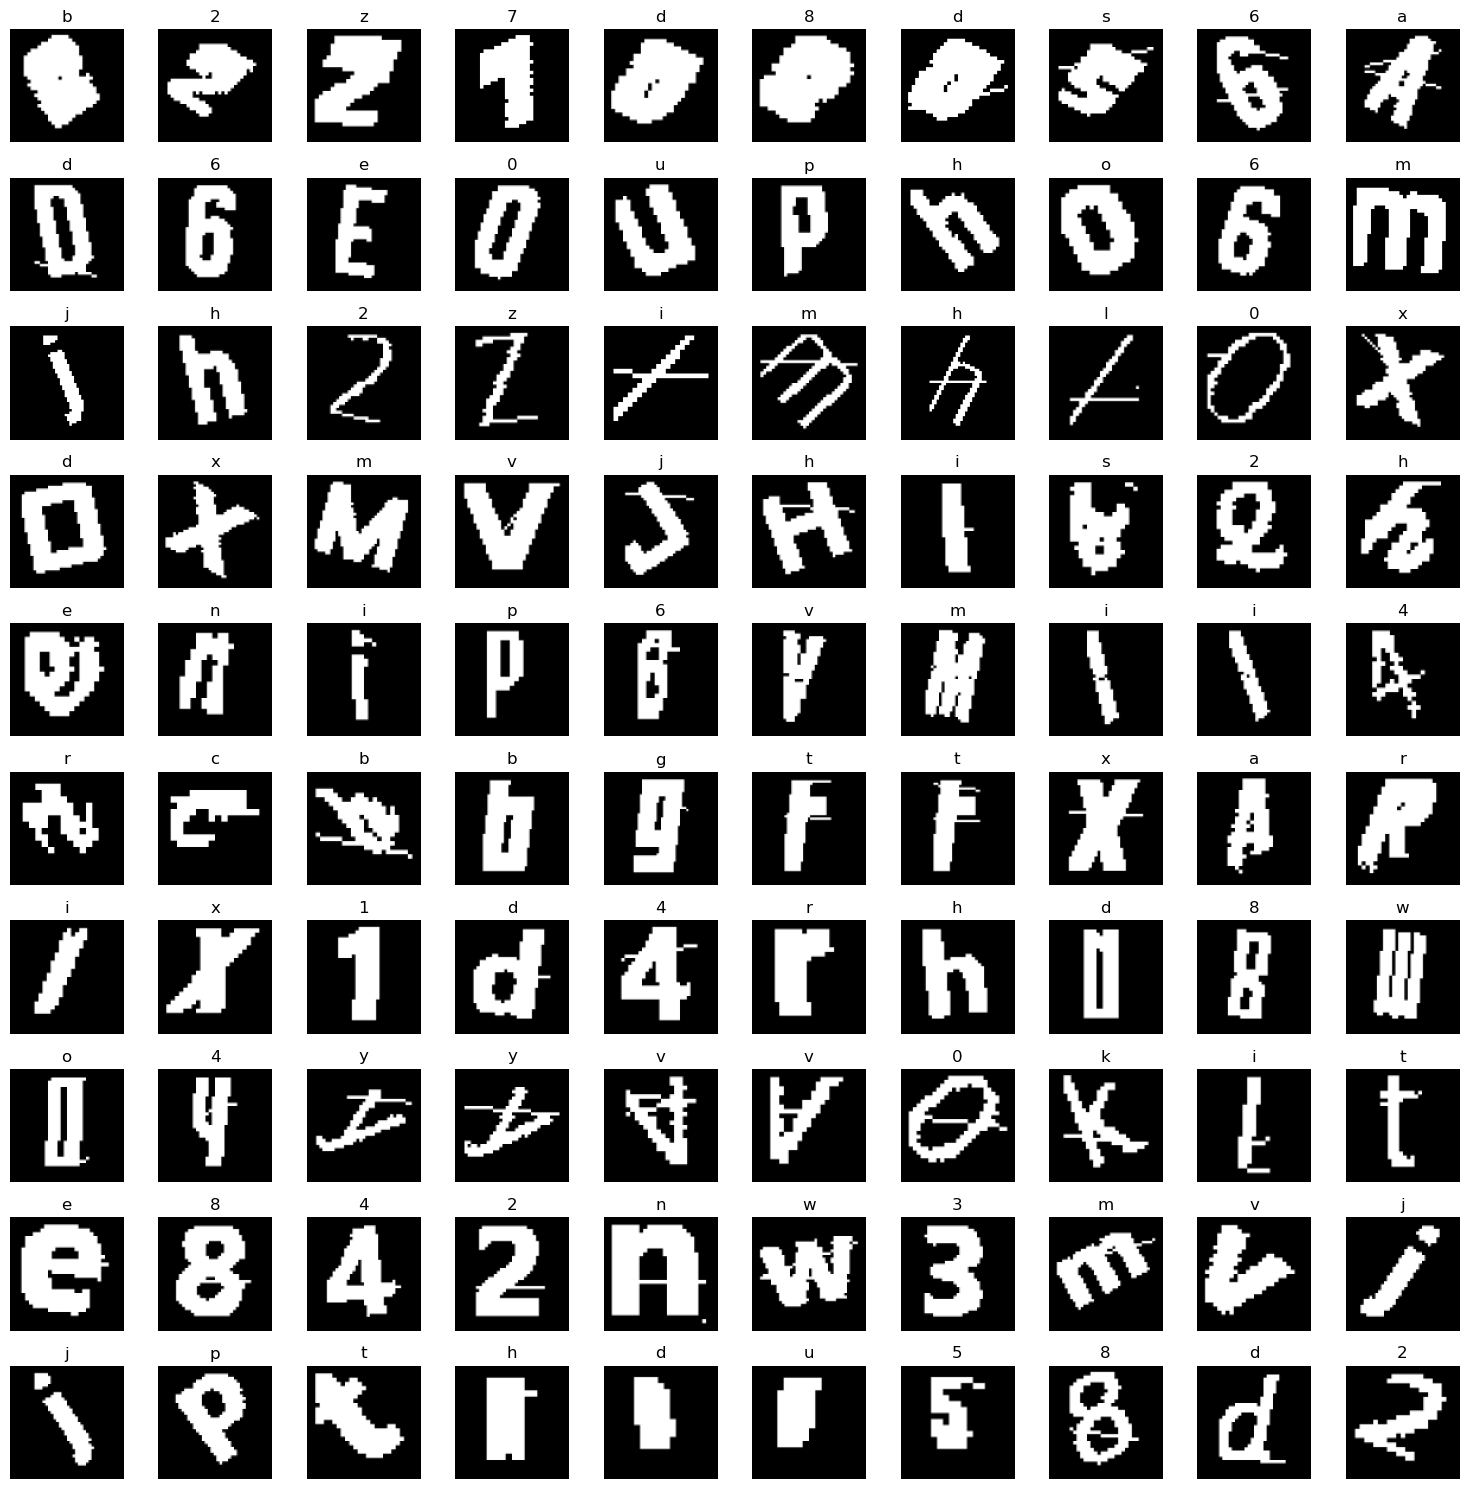

In [10]:

# Step 3: Deeper CNN Classifier for 96x96 images
class DeepCNN(nn.Module):
    """Deeper CNN for 96x96 character classification with more capacity"""
    def __init__(self, num_classes=36):
        super(DeepCNN, self).__init__()

        # Conv Block 1 (96x96 -> 48x48)
        self.conv1a = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1a = nn.BatchNorm2d(64)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1b = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Conv Block 2 (48x48 -> 24x24)
        self.conv2a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2a = nn.BatchNorm2d(128)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2b = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Conv Block 3 (24x24 -> 12x12)
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3a = nn.BatchNorm2d(256)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3b = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Conv Block 4 (12x12 -> 6x6)
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4a = nn.BatchNorm2d(512)
        self.conv4b = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4b = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)

        # Conv Block 5 (6x6 -> 3x3)
        self.conv5a = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5a = nn.BatchNorm2d(512)
        self.conv5b = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5b = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(2, 2)

        # Fully connected layers with more capacity
        self.fc1 = nn.Linear(512 * 3 * 3, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Block 1
        x = self.relu(self.bn1a(self.conv1a(x)))
        x = self.relu(self.bn1b(self.conv1b(x)))
        x = self.pool1(x)

        # Block 2
        x = self.relu(self.bn2a(self.conv2a(x)))
        x = self.relu(self.bn2b(self.conv2b(x)))
        x = self.pool2(x)

        # Block 3
        x = self.relu(self.bn3a(self.conv3a(x)))
        x = self.relu(self.bn3b(self.conv3b(x)))
        x = self.pool3(x)

        # Block 4
        x = self.relu(self.bn4a(self.conv4a(x)))
        x = self.relu(self.bn4b(self.conv4b(x)))
        x = self.pool4(x)

        # Block 5
        x = self.relu(self.bn5a(self.conv5a(x)))
        x = self.relu(self.bn5b(self.conv5b(x)))
        x = self.pool5(x)

        # Flatten and FC layers
        x = x.view(x.size(0), -1)
        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

# Character dataset class
class CharacterDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

        # Create character to index mapping
        all_chars = set()
        for label in labels:
            all_chars.update(label)

        self.char_to_idx = {char: idx for idx, char in enumerate(sorted(all_chars))}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.num_classes = len(self.char_to_idx)

        print(f"Found {self.num_classes} unique characters: {sorted(all_chars)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Data preparation for character classification
def prepare_character_data(images, labels, preprocessor, segmenter):
    """Extract individual characters from CAPTCHA images - FIXED to skip imperfect segmentations"""
    char_images = []
    char_labels = []
    skipped_count = 0
    total_count = 0

    for img, label in zip(images, labels):
        total_count += 1

        # Preprocess the image first to get binary image
        processed = preprocessor.preprocess(img)

        # Try segmentation on the preprocessed binary image
        char_boxes = segmenter.segment(
            processed,  # Pass preprocessed binary image
            img,
            min_char_width=3,
            min_char_height=5
        )

        # CRITICAL FIX: Only use perfectly segmented images for training
        if len(char_boxes) != len(label):
            skipped_count += 1
            continue  # Skip this image - avoid mislabeling

        # Extract character crops with IMPROVED aspect ratio preservation
        for i, box in enumerate(char_boxes):
            x1, y1, x2, y2 = box
            char_crop = processed[y1:y2, x1:x2]

            if char_crop.size == 0:
                continue

            # IMPROVED: Preserve aspect ratio by padding to square first
            h, w = char_crop.shape
            max_dim = max(h, w)

            # Create square canvas
            square = np.zeros((max_dim, max_dim), dtype=np.uint8)

            # Center the character in the square
            y_offset = (max_dim - h) // 2
            x_offset = (max_dim - w) // 2
            square[y_offset:y_offset+h, x_offset:x_offset+w] = char_crop

            # Add border padding (10% of size)
            border = max(2, int(max_dim * 0.1))
            square_padded = cv2.copyMakeBorder(
                square, border, border, border, border,
                cv2.BORDER_CONSTANT, value=0
            )

            # Now resize to 96x96 (maintains aspect ratio since it's square)
            char_resized = cv2.resize(square_padded, (96, 96), interpolation=cv2.INTER_AREA)

            # Normalize
            char_normalized = char_resized.astype(np.float32) / 255.0

            char_images.append(char_normalized)

            # Now we can safely assign labels (guaranteed correct alignment)
            char_labels.append(label[i])

    print(f"\n{'='*60}")
    print(f"Data Filtering Summary:")
    print(f"  Total images processed: {total_count}")
    print(f"  Perfect segmentations used: {total_count - skipped_count}")
    print(f"  Imperfect segmentations skipped: {skipped_count} ({skipped_count/total_count*100:.1f}%)")
    print(f"  Clean character samples extracted: {len(char_images)}")
    print(f"{'='*60}\n")

    return np.array(char_images), char_labels


# Prepare character data from ALL training images
print("\n" + "="*60)
print("Extracting character data from ALL training images...")
print("="*60)

char_images, char_labels = prepare_character_data(
    train_images, train_labels_cleaned, preprocessor, segmenter
)

print(f"\nExtracted {len(char_images)} character images from {len(train_images)} CAPTCHA images")
print(f"Sample character labels: {char_labels[:10]}")

# Display sample characters
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(100):
    if i < len(char_images):
        row = i // 10
        col = i % 10
        axes[row, col].imshow(char_images[i], cmap='gray')
        axes[row, col].set_title(char_labels[i])
        axes[row, col].axis('off')
plt.tight_layout()
plt.show()



Training character classifier on all character data...
Found 36 unique characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Epoch 1/50: Train Loss: 1.7520, Train Acc: 63.35%, Val Acc: 76.12%
  → New best model saved (epoch 1, val_acc: 76.12%)
Epoch 2/50: Train Loss: 1.2986, Train Acc: 78.54%, Val Acc: 80.80%
  → New best model saved (epoch 2, val_acc: 80.80%)
Epoch 3/50: Train Loss: 1.1895, Train Acc: 82.55%, Val Acc: 82.66%
  → New best model saved (epoch 3, val_acc: 82.66%)
Epoch 4/50: Train Loss: 1.1192, Train Acc: 84.82%, Val Acc: 85.04%
  → New best model saved (epoch 4, val_acc: 85.04%)
Epoch 5/50: Train Loss: 1.0714, Train Acc: 86.48%, Val Acc: 85.32%
  → New best model saved (epoch 5, val_acc: 85.32%)
Epoch 6/50: Train Loss: 1.0277, Train Acc: 87.86%, Val Acc: 86.00%
  → New best model saved (epoch 6, val_acc: 86.00%)
Epoch 7/50: Train Los

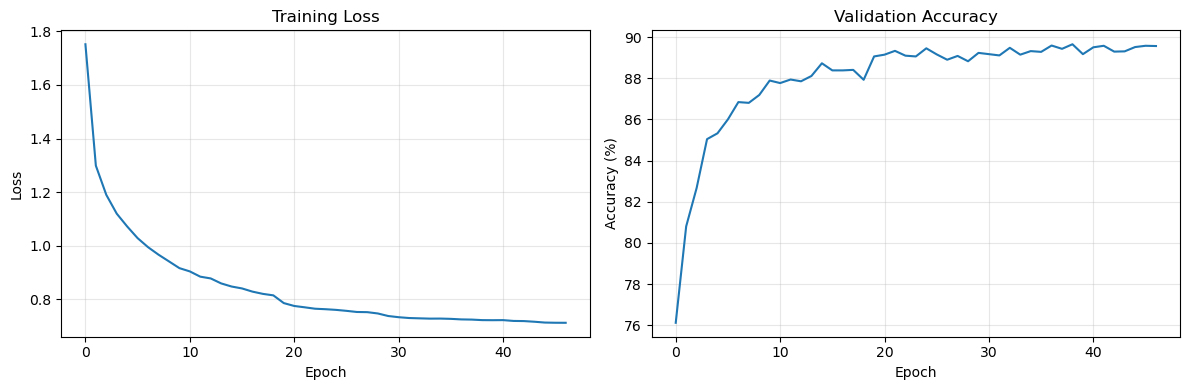


Final Training Loss: 0.7116
Final Validation Accuracy: 89.56%


In [11]:
# IMPROVED Training with Data Augmentation and Better Optimization
from typing import OrderedDict
import os

class DataAugmentation:
    """Simple data augmentation for character images"""

    def __init__(self, rotation_range=10, noise_std=0.05, image_size=96):
        self.rotation_range = rotation_range
        self.noise_std = noise_std
        self.image_size = image_size

    def __call__(self, img):
        """Apply random augmentations to image tensor"""
        img = img.clone()  # Create a copy to avoid modifying original

        # Random rotation
        if np.random.random() > 0.5:
            angle = np.random.uniform(-self.rotation_range, self.rotation_range)
            img_np = img.squeeze().numpy().astype(np.float32)
            center = (self.image_size // 2, self.image_size // 2)  # FIXED: Use dynamic center
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            img_np = cv2.warpAffine(img_np, M, (self.image_size, self.image_size), borderValue=0)
            img = torch.from_numpy(img_np).unsqueeze(0).float()

        # Random noise
        if np.random.random() > 0.5:
            noise = torch.randn_like(img) * self.noise_std
            img = img + noise
            img = torch.clamp(img, 0, 1)

        return img


# Training the character classifier - IMPROVED VERSION
def train_character_classifier(char_images, char_labels, num_epochs=50, batch_size=128):
    """Train the CNN with data augmentation and improved optimization"""

    # Create dataset
    dataset = CharacterDataset(char_images, char_labels)

    # Split data
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    # Create data loaders
    # FIXED: drop_last=True to avoid BatchNorm error with single-sample batches
    # OPTIMIZED: Increased batch_size from 32 to 128 for better GPU utilization
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=True,
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
    )

    # Initialize model
    model = DeepCNN(num_classes=dataset.num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # IMPROVED: Label smoothing for better generalization
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # IMPROVED: AdamW optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

    # IMPROVED: ReduceLROnPlateau scheduler (better than StepLR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=3
    )

    # Data augmentation
    augment = DataAugmentation(rotation_range=10, noise_std=0.05, image_size=96)

    # Training loop
    train_losses = []
    val_accuracies = []
    best_val_acc = 0
    patience_counter = 0
    early_stop_patience = 8  # Wait 8 epochs before stopping
    best_model_state = None
    best_epoch = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.unsqueeze(1).float().to(device)

            # Apply data augmentation during training
            if epoch > 0:  # Skip first epoch for faster initial convergence
                # Apply augmentation to the entire batch at once
                augmented_data = []
                for i in range(data.size(0)):
                    augmented_data.append(augment(data[i]))
                data = torch.stack(augmented_data)

            target = torch.tensor(
                [dataset.char_to_idx.get(char, 0) for char in target]
            ).to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()

            # IMPROVED: Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validation
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data = data.unsqueeze(1).float().to(device)
                target = torch.tensor(
                    [dataset.char_to_idx.get(char, 0) for char in target]
                ).to(device)

                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * correct / total

        train_losses.append(train_loss)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%"
        )

        # Update learning rate based on validation accuracy
        scheduler.step(val_acc)

        # Early stopping check with best model saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model weights
            best_model_state = model.state_dict().copy()
            best_epoch = epoch + 1
            print(
                f"  → New best model saved (epoch {best_epoch}, val_acc: {best_val_acc:.2f}%)"
            )
        else:
            patience_counter += 1

        if patience_counter >= early_stop_patience:
            print(
                f"Early stopping triggered at epoch {epoch+1}. Best val acc: {best_val_acc:.2f}%"
            )
            break

    # Restore best model weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(
            f"\n✓ Restored best model weights from epoch {best_epoch} (val_acc: {best_val_acc:.2f}%)"
        )
    else:
        print(f"\n⚠ No improvement during training - using final model")

    return model, dataset, train_losses, val_accuracies


if not os.path.exists("captcha_classifier.pth"):
    # Train the model with optimized parameters
    print("\n" + "=" * 60)
    print("Training character classifier on all character data...")
    print("=" * 60)

    model, char_dataset, train_losses, val_accuracies = train_character_classifier(
        char_images,
        char_labels,
        num_epochs=50,
        batch_size=128,  # FIXED: Increased epochs and batch size
    )

    # Plot training progress
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses)
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True, alpha=0.3)

    ax2.plot(val_accuracies)
    ax2.set_title("Validation Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy (%)")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
else:
    char_dataset = CharacterDataset(char_images, char_labels)
    ckpt = torch.load("captcha_classifier_2810.pth", map_location="cpu")

    # Rebuild model with the saved num_classes if present
    saved_num_classes = ckpt.get("num_classes")
    if saved_num_classes is not None and getattr(model, "num_classes", None) != saved_num_classes:
        model = DeepCNN(num_classes=saved_num_classes)

    # Extract the real state dict (handles both raw state_dict and wrapped checkpoints)
    state_dict = ckpt["model_state_dict"] if "model_state_dict" in ckpt else ckpt

    # If it was saved with DataParallel, strip the 'module.' prefix
    if any(k.startswith("module.") for k in state_dict.keys()):
        new_state = OrderedDict((k[len("module."):], v) if k.startswith("module.") else (k, v)
                                for k, v in state_dict.items())
        state_dict = new_state

    model.load_state_dict(state_dict, strict=True)
    model.eval()

In [12]:
# Complete CAPTCHA Prediction Pipeline
class CAPTCHAPredictor:
    def __init__(self, model, char_dataset, preprocessor, segmenter, device=None):
        self.model = model
        self.char_dataset = char_dataset
        self.preprocessor = preprocessor
        self.segmenter = segmenter
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()

    def predict_captcha(self, image):
        """Predict the full CAPTCHA text from an image"""
        # Step 1: Preprocess the image first to get binary image
        processed = self.preprocessor.preprocess(image)

        # Step 2: Segment on the preprocessed binary image
        char_boxes = self.segmenter.segment(
            processed,  # Pass preprocessed binary image
            image,
            min_char_width=3,
            min_char_height=5
        )

        # Step 3: Extract and classify each character with IMPROVED aspect ratio preservation
        predicted_chars = []

        for box in char_boxes:
            x1, y1, x2, y2 = box

            # Extract character
            char_crop = processed[y1:y2, x1:x2]

            if char_crop.size == 0:
                continue

            # IMPROVED: Preserve aspect ratio by padding to square first
            h, w = char_crop.shape
            max_dim = max(h, w)

            # Create square canvas
            square = np.zeros((max_dim, max_dim), dtype=np.uint8)

            # Center the character in the square
            y_offset = (max_dim - h) // 2
            x_offset = (max_dim - w) // 2
            square[y_offset:y_offset+h, x_offset:x_offset+w] = char_crop

            # Add border padding (10% of size)
            border = max(2, int(max_dim * 0.1))
            square_padded = cv2.copyMakeBorder(
                square, border, border, border, border,
                cv2.BORDER_CONSTANT, value=0
            )

            # Now resize to 96x96
            char_resized = cv2.resize(square_padded, (96, 96), interpolation=cv2.INTER_AREA)

            # Normalize
            char_normalized = char_resized.astype(np.float32) / 255.0

            # Convert to tensor
            char_tensor = torch.from_numpy(char_normalized).unsqueeze(0).unsqueeze(0).to(self.device)

            # Predict
            with torch.no_grad():
                output = self.model(char_tensor)
                _, predicted_idx = torch.max(output.data, 1)
                predicted_char = self.char_dataset.idx_to_char[predicted_idx.item()]
                predicted_chars.append(predicted_char)

        # Join characters into string
        predicted_text = ''.join(predicted_chars)

        return predicted_text, char_boxes

    def visualize_prediction(self, image, predicted_text, true_label, char_boxes):
        """Visualize the prediction result"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Original image
        if len(image.shape) == 3:
            axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        else:
            axes[0].imshow(image, cmap='gray')
        axes[0].set_title(f"True: {true_label}")
        axes[0].axis('off')

        # Prediction with boxes
        processed = self.preprocessor.preprocess(image)
        axes[1].imshow(processed, cmap='gray')
        axes[1].set_title(f"Predicted: {predicted_text}")

        for box in char_boxes:
            x1, y1, x2, y2 = box
            rect = Rectangle((x1, y1), x2-x1, y2-y1,
                           linewidth=2, edgecolor='red', facecolor='none')
            axes[1].add_patch(rect)

        axes[1].axis('off')

        # Color code the title based on correctness
        if predicted_text == true_label:
            axes[1].title.set_color('green')
        else:
            axes[1].title.set_color('red')

        plt.tight_layout()
        plt.show()

# Initialize predictor
print("\n" + "="*60)
print("Initializing CAPTCHA Predictor...")
print("="*60)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictor = CAPTCHAPredictor(model, char_dataset, preprocessor, segmenter, device)

print(f"Using device: {device}")
print("Predictor ready!")



Initializing CAPTCHA Predictor...
Using device: cpu
Predictor ready!



Testing predictor on sample images...
Found 2000 images. Loading...
Loaded 2000/2000 (100.0%)
Test images length: 2000
Test labels length: 2000

--- Sample 1 ---
True Label:      002e23
Predicted Text:  002e23
Match: True


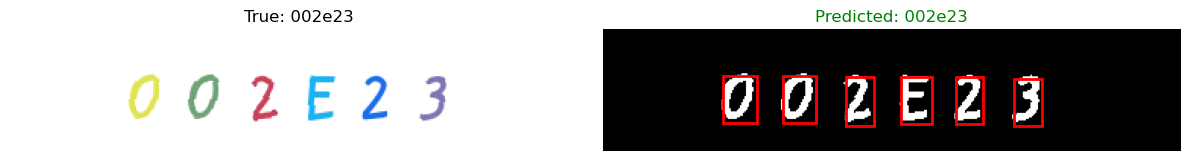


--- Sample 2 ---
True Label:      03yl9s
Predicted Text:  03yl9s
Match: True


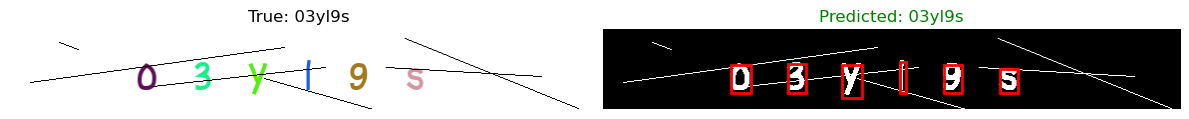


--- Sample 3 ---
True Label:      03yuav5
Predicted Text:  o3yuav5
Match: False


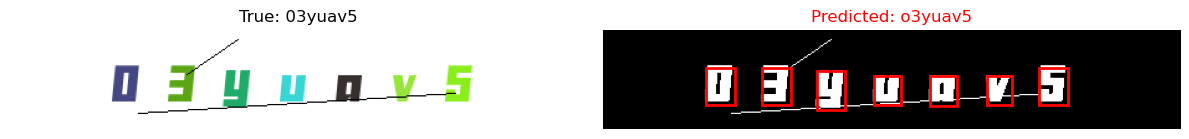


--- Sample 4 ---
True Label:      03zl9o
Predicted Text:  o3zl9o
Match: False


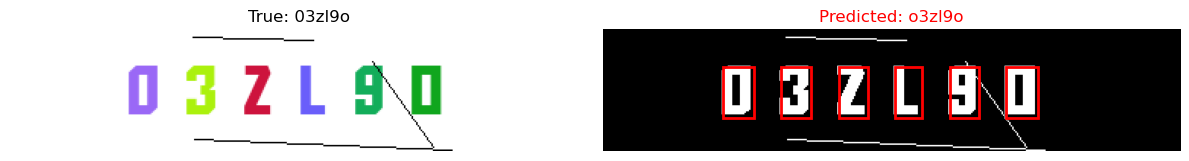


--- Sample 5 ---
True Label:      04zqohgi
Predicted Text:  04z4oh9i
Match: False


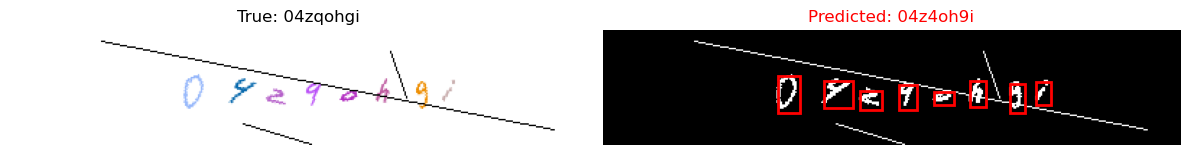


--- Sample 6 ---
True Label:      05htm
Predicted Text:  05htm
Match: True


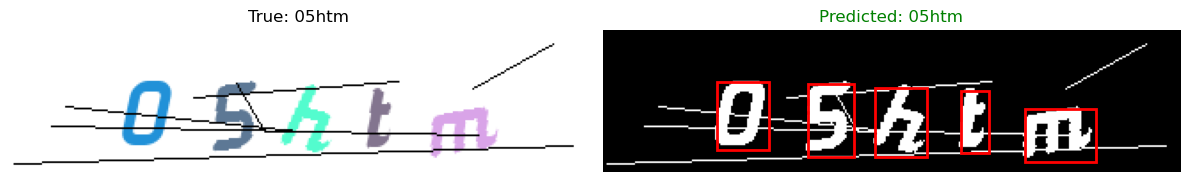


--- Sample 7 ---
True Label:      05pb
Predicted Text:  o5pb
Match: False


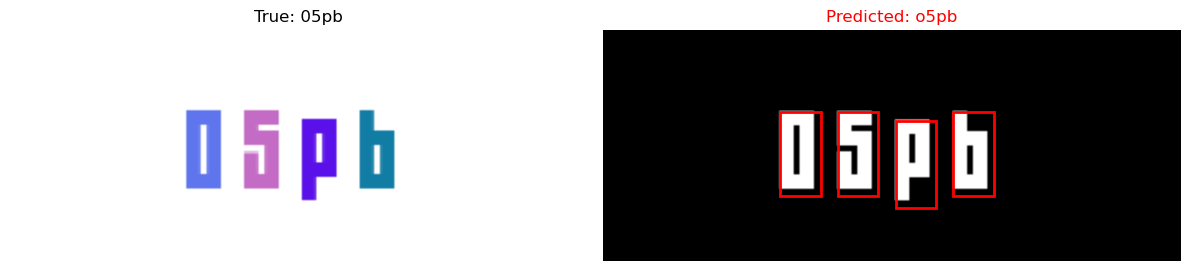


--- Sample 8 ---
True Label:      07oj
Predicted Text:  07oj
Match: True


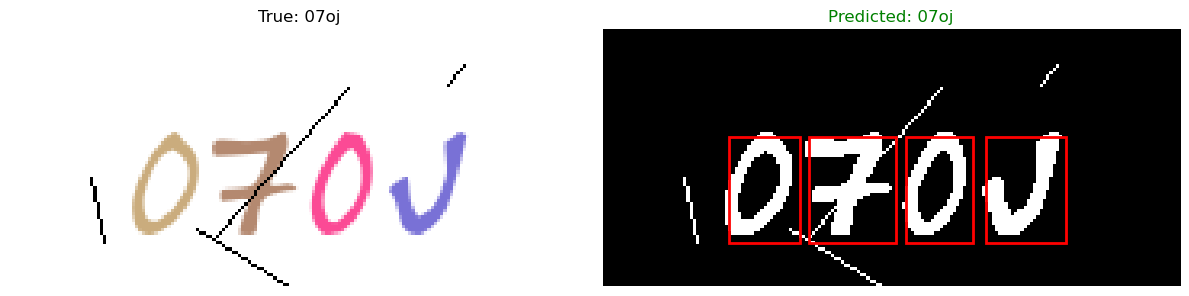


--- Sample 9 ---
True Label:      07z0
Predicted Text:  07z0
Match: True


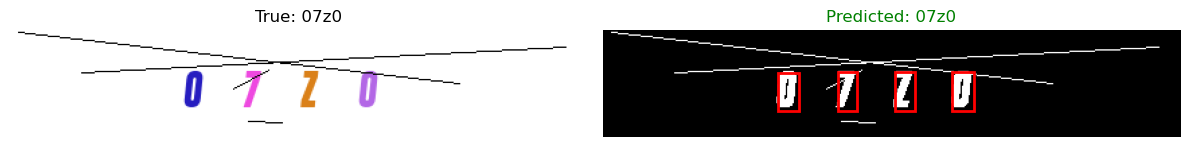


--- Sample 10 ---
True Label:      08ft2e2z
Predicted Text:  o8ft2e2z
Match: False


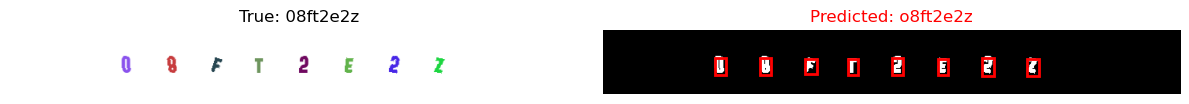


Evaluating on FULL test set...
Processing 2000 test images...
Progress: 0/2000 (0.0%)
Progress: 100/2000 (5.0%)
Progress: 200/2000 (10.0%)
Progress: 300/2000 (15.0%)
Progress: 400/2000 (20.0%)
Progress: 500/2000 (25.0%)
Progress: 600/2000 (30.0%)
Progress: 700/2000 (35.0%)
Progress: 800/2000 (40.0%)
Progress: 900/2000 (45.0%)
Progress: 1000/2000 (50.0%)
Progress: 1100/2000 (55.0%)
Progress: 1200/2000 (60.0%)
Progress: 1300/2000 (65.0%)
Progress: 1400/2000 (70.0%)
Progress: 1500/2000 (75.0%)
Progress: 1600/2000 (80.0%)
Progress: 1700/2000 (85.0%)
Progress: 1800/2000 (90.0%)
Progress: 1900/2000 (95.0%)

Completed: 2000/2000 (100%)

EVALUATION RESULTS
Total test images: 2000
Exact match accuracy: 51.55% (1031/2000)
Character-level accuracy: 79.58% (9564/12018)

Sample incorrect predictions:
Image 2: True='03yuav5', Predicted='o3yuav5'
Image 3: True='03zl9o', Predicted='o3zl9o'
Image 4: True='04zqohgi', Predicted='04z4oh9i'
Image 6: True='05pb', Predicted='o5pb'
Image 9: True='08ft2e2z', 

In [13]:
# Test predictor on sample images
print("\n" + "="*60)
print("Testing predictor on sample images...")
print("="*60)

n_test_samples = min(10, len(test_images))

test_images, test_labels = load_captcha_data_fast("../data/test", max_samples=None)
test_labels_cleaned = [clean_label(label) for label in test_labels]
print(f"Test images length: {len(test_images)}")
print(f"Test labels length: {len(test_labels_cleaned)}")

for i in range(n_test_samples):
    print(f"\n--- Sample {i+1} ---")
    predicted_text, char_boxes = predictor.predict_captcha(test_images[i])
    true_label = test_labels_cleaned[i]

    print(f"True Label:      {true_label}")
    print(f"Predicted Text:  {predicted_text}")
    print(f"Match: {predicted_text == true_label}")

    predictor.visualize_prediction(test_images[i], predicted_text, true_label, char_boxes)

# Evaluate on full test set
print("\n" + "="*60)
print("Evaluating on FULL test set...")
print("="*60)

correct = 0
total = len(test_images)
char_correct = 0
char_total = 0

predictions = []
ground_truths = []

print(f"Processing {total} test images...")

for i, (img, true_label) in enumerate(zip(test_images, test_labels_cleaned)):
    if i % 100 == 0:
        print(f"Progress: {i}/{total} ({i/total*100:.1f}%)")

    try:
        predicted_text, _ = predictor.predict_captcha(img)
        predictions.append(predicted_text)
        ground_truths.append(true_label)

        # Exact match accuracy
        if predicted_text == true_label:
            correct += 1

        # Character-level accuracy
        for pred_char, true_char in zip(predicted_text, true_label):
            char_total += 1
            if pred_char == true_char:
                char_correct += 1

        # Account for length differences
        if len(predicted_text) != len(true_label):
            char_total += abs(len(predicted_text) - len(true_label))

    except Exception as e:
        predictions.append("")
        ground_truths.append(true_label)
        print(f"Error on image {i}: {e}")

print(f"\nCompleted: {total}/{total} (100%)")

# Calculate metrics
exact_match_accuracy = 100 * correct / total
char_accuracy = 100 * char_correct / char_total if char_total > 0 else 0

print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"Total test images: {total}")
print(f"Exact match accuracy: {exact_match_accuracy:.2f}% ({correct}/{total})")
print(f"Character-level accuracy: {char_accuracy:.2f}% ({char_correct}/{char_total})")

# Show some incorrect predictions
print("\n" + "="*60)
print("Sample incorrect predictions:")
print("="*60)

incorrect_samples = []
for i, (pred, true) in enumerate(zip(predictions, ground_truths)):
    if pred != true:
        incorrect_samples.append((i, pred, true))

if incorrect_samples:
    for idx, pred, true in incorrect_samples[:10]:
        print(f"Image {idx}: True='{true}', Predicted='{pred}'")

# Save the trained model
print("\n" + "="*60)
print("Saving trained model...")
print("="*60)

# Save model weights
model_path = 'captcha_classifier.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'char_to_idx': char_dataset.char_to_idx,
    'idx_to_char': char_dataset.idx_to_char,
    'num_classes': char_dataset.num_classes,
}, model_path)

# print(f"Model saved to: {model_path}")
print(f"Number of classes: {char_dataset.num_classes}")
print(f"Characters: {sorted(char_dataset.char_to_idx.keys())}")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"✓ Trained on {len(train_images)} CAPTCHA images")
print(f"✓ Extracted {len(char_images)} character samples")
print(f"✓ Tested on {len(test_images)} CAPTCHA images")
print(f"✓ Exact match accuracy: {exact_match_accuracy:.2f}%")
print(f"✓ Character accuracy: {char_accuracy:.2f}%")
# print(f"✓ Model saved to: {model_path}")
print("="*60)